We want to now demonstrate how the Aurora moves using ewograms!

In [1]:
import numpy as np #Lets handle our imports now for section A
import matplotlib.pyplot as plt
import asilib
import asilib.asi
from datetime import datetime, timedelta
from scipy.optimize import curve_fit
from viresclient import set_token
from viresclient import SwarmRequest
import geopack.geopack as gp

import scienceplots

plt.style.use(['science','no-latex'])
alt=150

Load IGRF coefficients ...


In [2]:
time_array=(datetime(2022,12,19,14,2), datetime(2022,12,19,14,8))

Now for the hard part, the pixel intensity
Since the satellite as seen in figure 1 passes through the arc pretty fast, we should increase the resolution of the pixel intensity by super imposing 

Lets define the imager

In [14]:
asi=asilib.asi.trex_rgb(location_code='yknf', alt=alt,   time_range=time_array, colors='r')


Transition Region Explorer (TREx) RGB data is courtesy of Space Environment Canada (space-environment.ca). Use of the data must adhere to the rules of the road for that dataset.  Please see below for the required data acknowledgement. Any questions about the TREx instrumentation or data should be directed to the University of Calgary, Emma Spanswick (elspansw@ucalgary.ca) and/or Eric Donovan (edonovan@ucalgary.ca).

“The Transition Region Explorer RGB (TREx RGB) is a joint Canada Foundation for Innovation and Canadian Space Agency project developed by the University of Calgary. TREx-RGB is operated and maintained by Space Environment Canada with the support of the Canadian Space Agency (CSA) [23SUGOSEC].”


c:\Users\1101w\anaconda3\envs\pymc_env\Lib\site-packages\asilib\conjunction.py:425: UserWarning: Some latitude or longitude values are outside of the skymap lat/lon arrays or are invalid. The equal area mask will be all NaNs.
  warnings.warn(


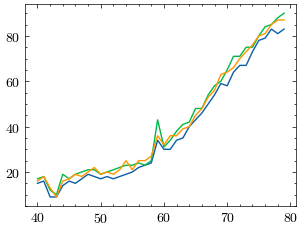

In [15]:

#sat_lla_E=footprint(time_array[0],latitude_E, longitude_E, altitude_E, alt, vsw=[-345,12,-12])

conjunction_obj = asilib.Conjunction(asi, (np.array(Etime), sat_lla_E.T))
sat_azimuth_elevation, sat_azel_pixels = conjunction_obj.map_azel()
area_intensity = conjunction_obj.intensity()
area_mask = conjunction_obj.equal_area(box=(10,10))
# Need to change masked NaNs to 0s so we can plot the rectangular area contours.
area_mask[np.where(np.isnan(area_mask))] = 0
plt.plot(area_intensity) #This gives us a resolution of 3Hz.


Now lets look at images and define some lines for ewograms

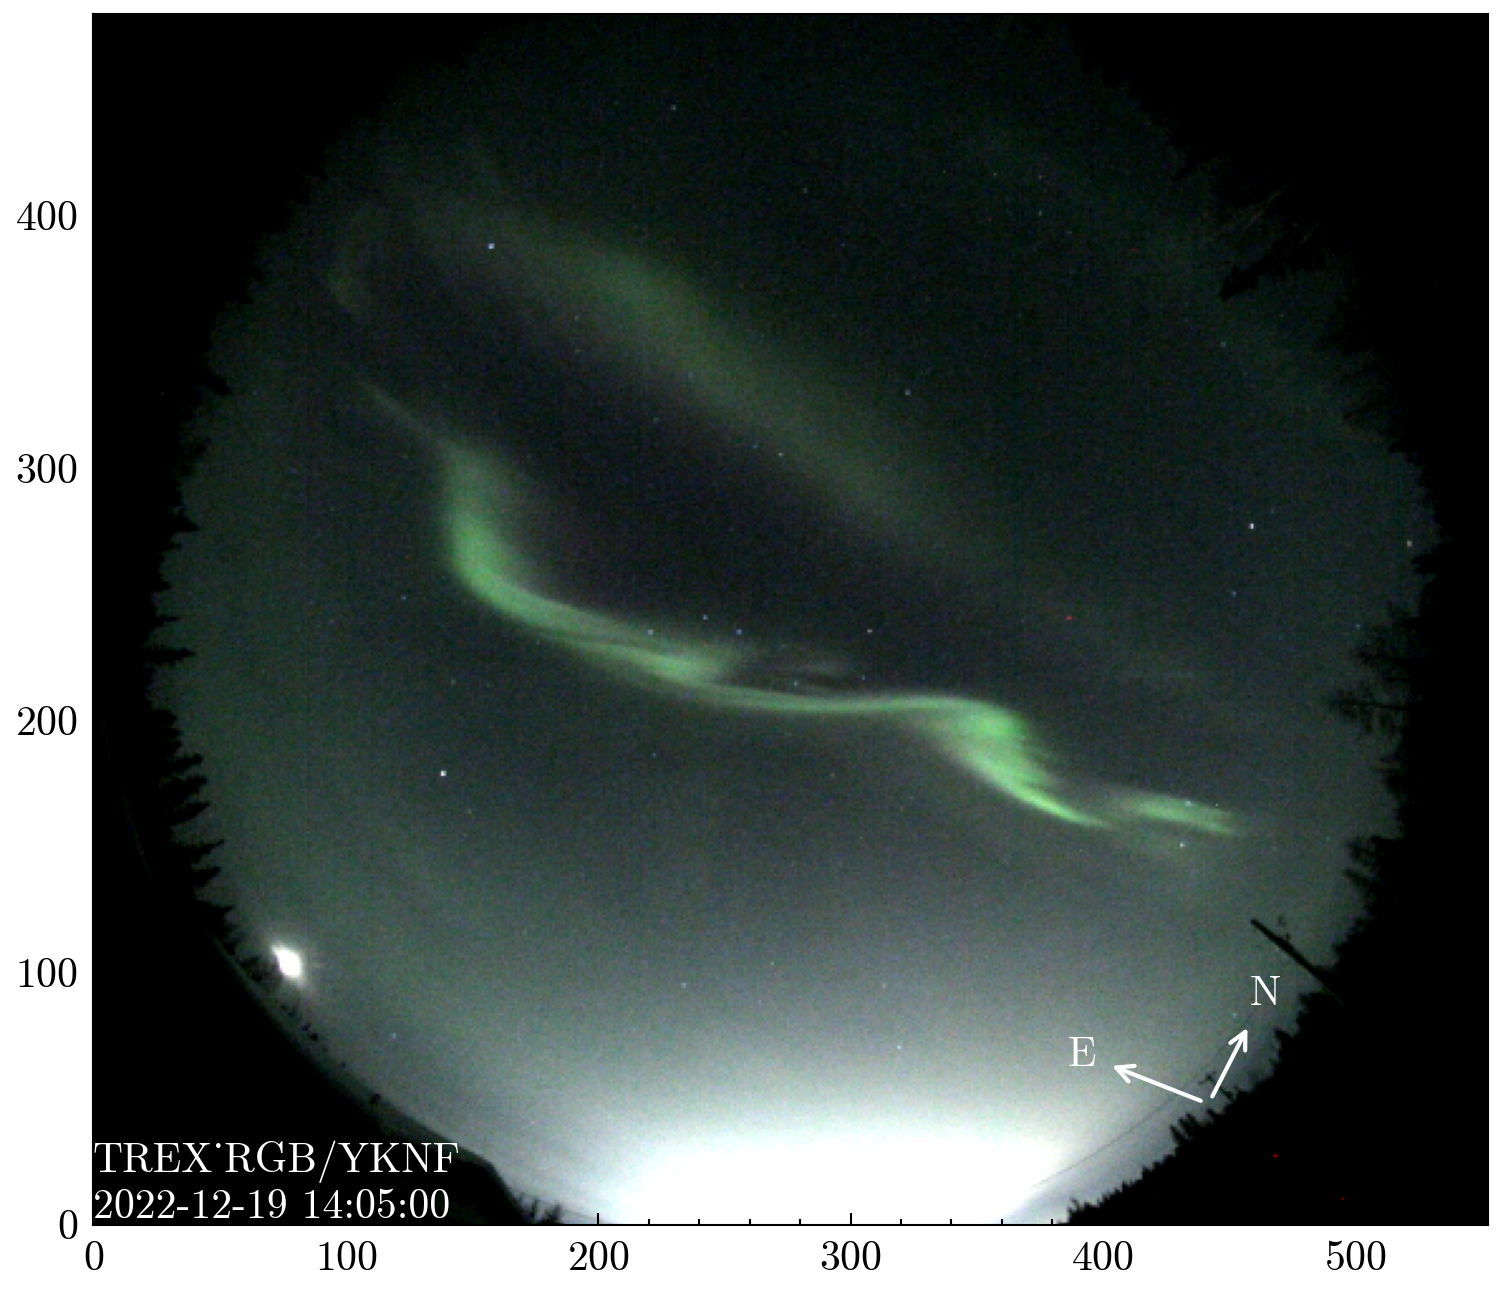

In [17]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
from datetime import datetime
asi_single=asilib.asi.trex_rgb(location_code='yknf', alt=alt,  time=datetime(2022,12,19,14,5), colors='rgb')

ax, im_good = asi_single.plot_fisheye(ax=ax)


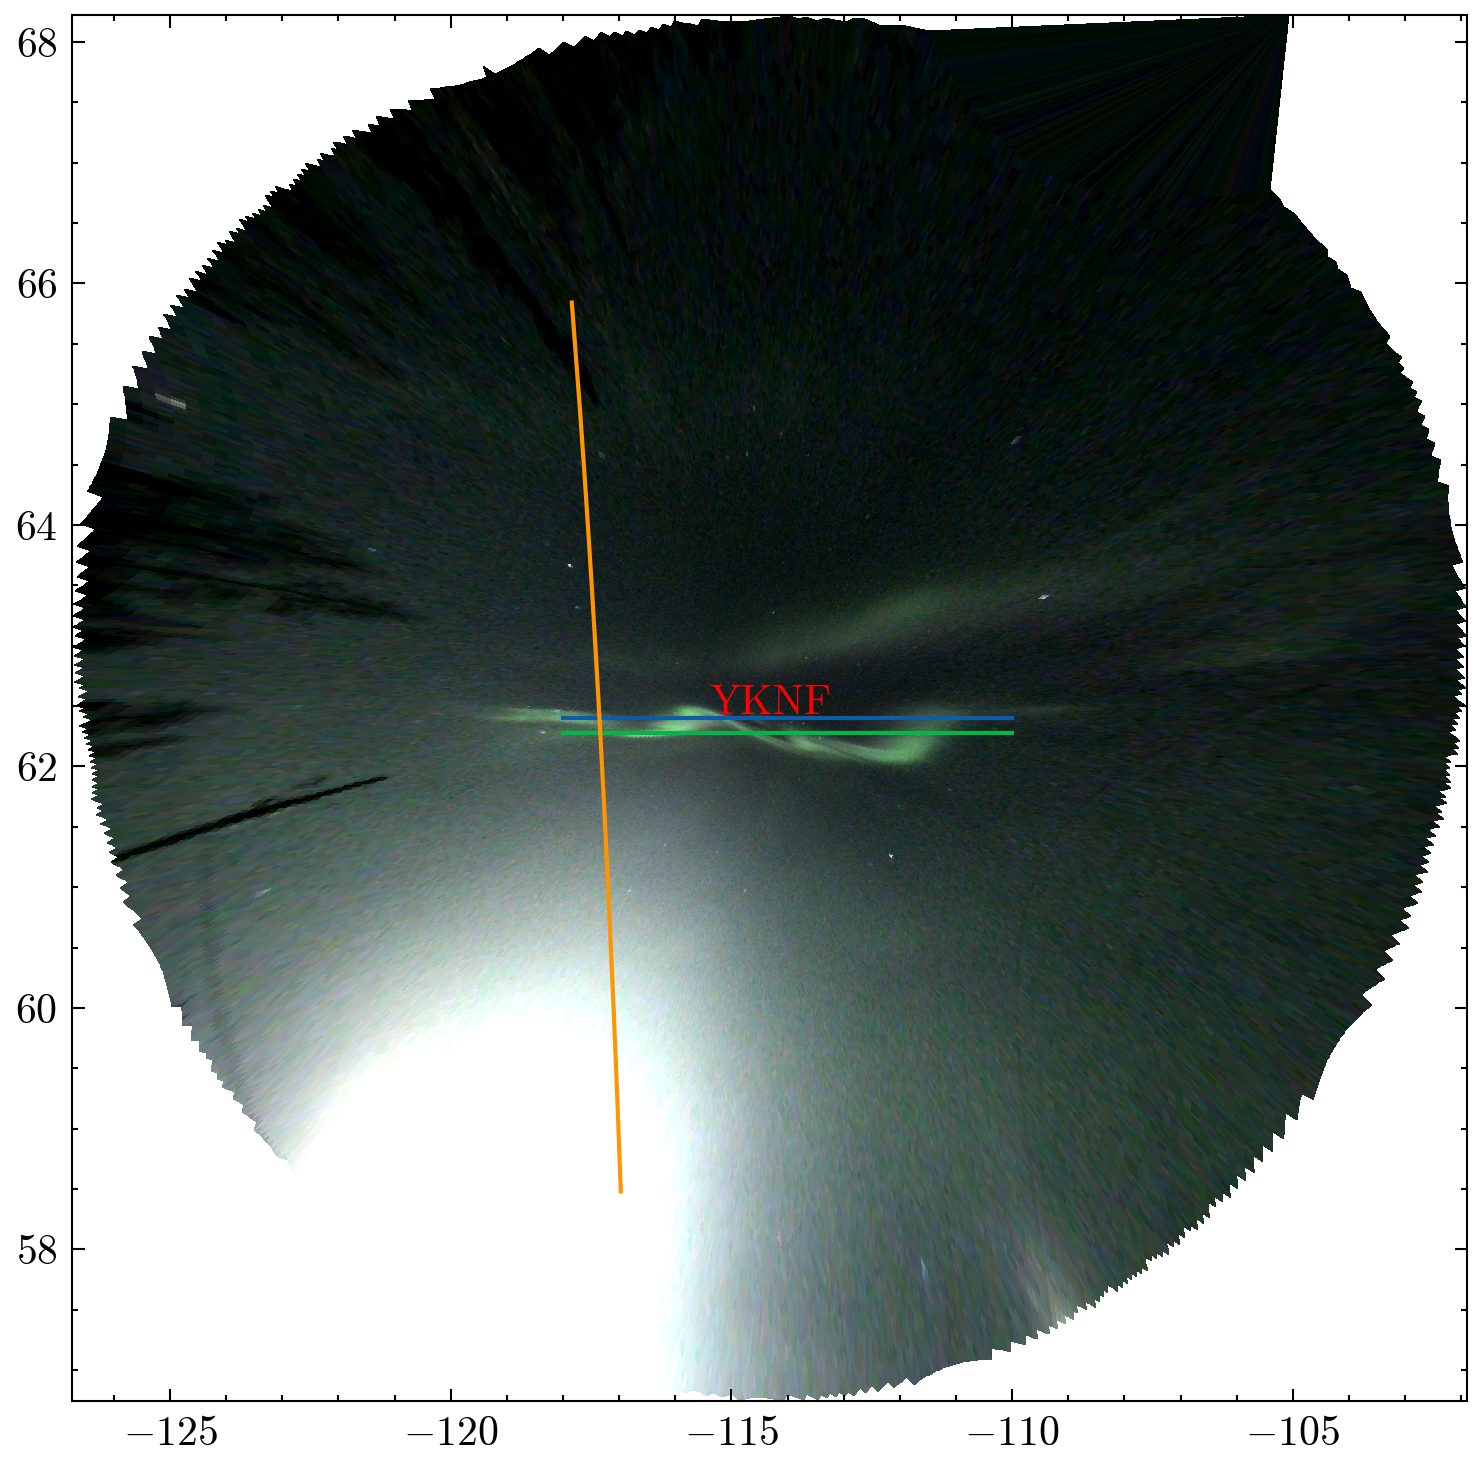

In [18]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300)
ax, im_good = asi_single.plot_map(ax=ax)
coords=im_good.get_coordinates()
x_coords=coords[:,:,0]
y_coords=coords[:,:,1]
x = np.linspace(-118, -110, 200)
y= np.linspace(62.4, 62.4, 200)
plt.plot(x,y)
y= np.linspace(62.28, 62.28, 200)
plt.plot(x,y)




In [19]:


# grid_lats, grid_lons: 2D arrays representing the latitude and longitude grid
# line_lats, line_lons: 1D arrays representing the latitude and longitude of the line

def find_closest_grid_points(grid_lats, grid_lons, line_lats, line_lons):
    # Reshape line_lats and line_lons for broadcasting with the grid
    line_lats_reshaped = line_lats[:, np.newaxis, np.newaxis]  # Shape: (num_points, 1, 1)
    line_lons_reshaped = line_lons[:, np.newaxis, np.newaxis]  # Shape: (num_points, 1, 1)

    # Compute squared Euclidean distances using broadcasting
    lat_diff = grid_lats[np.newaxis, :, :] - line_lats_reshaped  # Shape: (num_points, grid_lat_dim, grid_lon_dim)
    lon_diff = grid_lons[np.newaxis, :, :] - line_lons_reshaped  # Shape: (num_points, grid_lat_dim, grid_lon_dim)
    distances = lat_diff**2 + lon_diff**2  # Shape: (num_points, grid_lat_dim, grid_lon_dim)

    # Find the flat index of the minimum distance for each point along the grid axes
    min_indices_flat = np.argmin(distances.reshape(distances.shape[0], -1), axis=1)  # Shape: (num_points,)

    # Convert flat indices back to 2D grid indices for all points at once
    grid_shape = grid_lats.shape
    closest_indices = np.stack(np.unravel_index(min_indices_flat, grid_shape), axis=1)

    return closest_indices.T

# Example usage
grid_lats = np.array(y_coords)  # Replace y_coords with the actual grid latitude array (2D)
grid_lons = np.array(x_coords)  # Replace x_coords with the actual grid longitude array (2D)

line_lats = np.array(y)         # Replace y with the actual line latitude array (1D)
line_lons = np.array(x)         # Replace x with the actual line longitude array (1D)

closest_indices = find_closest_grid_points(grid_lats, grid_lons, line_lats, line_lons)


2022-12-19 14:02:00 2022-12-19 14:08:00


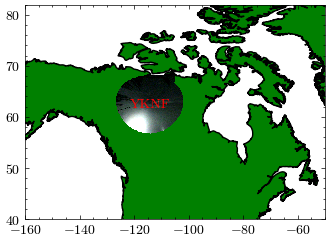

In [20]:
import numpy as np
# Define the coordinates for y values
x_1 = np.linspace(-119, -107, 500)  # x-coordinates (longitude range)
y_values = np.array([62.28, 62.32, 62.36, 62.40])  # y-values for different lines (latitude)
y_target = np.tile(y_values[:, np.newaxis], (1, 500))  # 2D array of shape (4, 800)
print(time_array[0], time_array[-1])
# Initialize ASI object
asi = asilib.asi.trex_rgb(location_code='yknf', alt=alt ,  time_range=(time_array[0], time_array[-1]))

# Lists to hold results
pixel_closest_list = np.zeros((4, 120, 500, 3), dtype=np.uint8)
time_ewo = []

movie_generator = asi.animate_map_gen()
closest_indices = []
for i, (time, image, _, im) in enumerate(movie_generator):
    if i ==0:
        coords = im.get_coordinates()
        grid_lons = coords[:, :, 0]
        grid_lats = coords[:, :, 1]
        # Loop over each y-value target line
        for j in range(len(y_values)):
            # Get closest grid points for all 800 points on the line
            closest_indices.append(np.transpose(find_closest_grid_points(grid_lats, grid_lons, y_target[j], x_1))) 
            
            # Ensure closest_indices has shape (800, 2) where 800 points correspond to x_1
            # closest_indices[0] = indices of closest grid points for latitudes
            # closest_indices[1] = indices of closest grid points for longitudes

            if closest_indices[j].shape[0] == 500:
                # Fetch the RGB values for all 800 closest grid points using advanced indexing
                pixel_values = image[closest_indices[j][:, 0], closest_indices[j][:, 1], :]  # shape (800, 3)
                
                # Append all pixel values for this y-value line
                pixel_closest_list[j][i] = pixel_values
            else:
                print(f"Error: closest_indices does not match the expected shape for y_value index {j}")
    else:
         for j in range(len(y_values)):
            # Get closest grid points for all 800 points on the line
            
            # Ensure closest_indices has shape (800, 2) where 800 points correspond to x_1
            # closest_indices[0] = indices of closest grid points for latitudes
            # closest_indices[1] = indices of closest grid points for longitudes

            if closest_indices[j].shape[0] == 500:
                # Fetch the RGB values for all 800 closest grid points using advanced indexing
                pixel_values = image[closest_indices[j][:, 0], closest_indices[j][:, 1], :]  # shape (800, 3)
                
                # Append all pixel values for this y-value line
                pixel_closest_list[j][i] = pixel_values
            else:
                print(f"Error: closest_indices does not match the expected shape for y_value index {j}")


    time_ewo.append(time)
    if i==119:
        break

# Unpack the pixel closest lists for each y-value
pixel_closest_30, pixel_closest_32, pixel_closest_34, pixel_closest_36 = pixel_closest_list


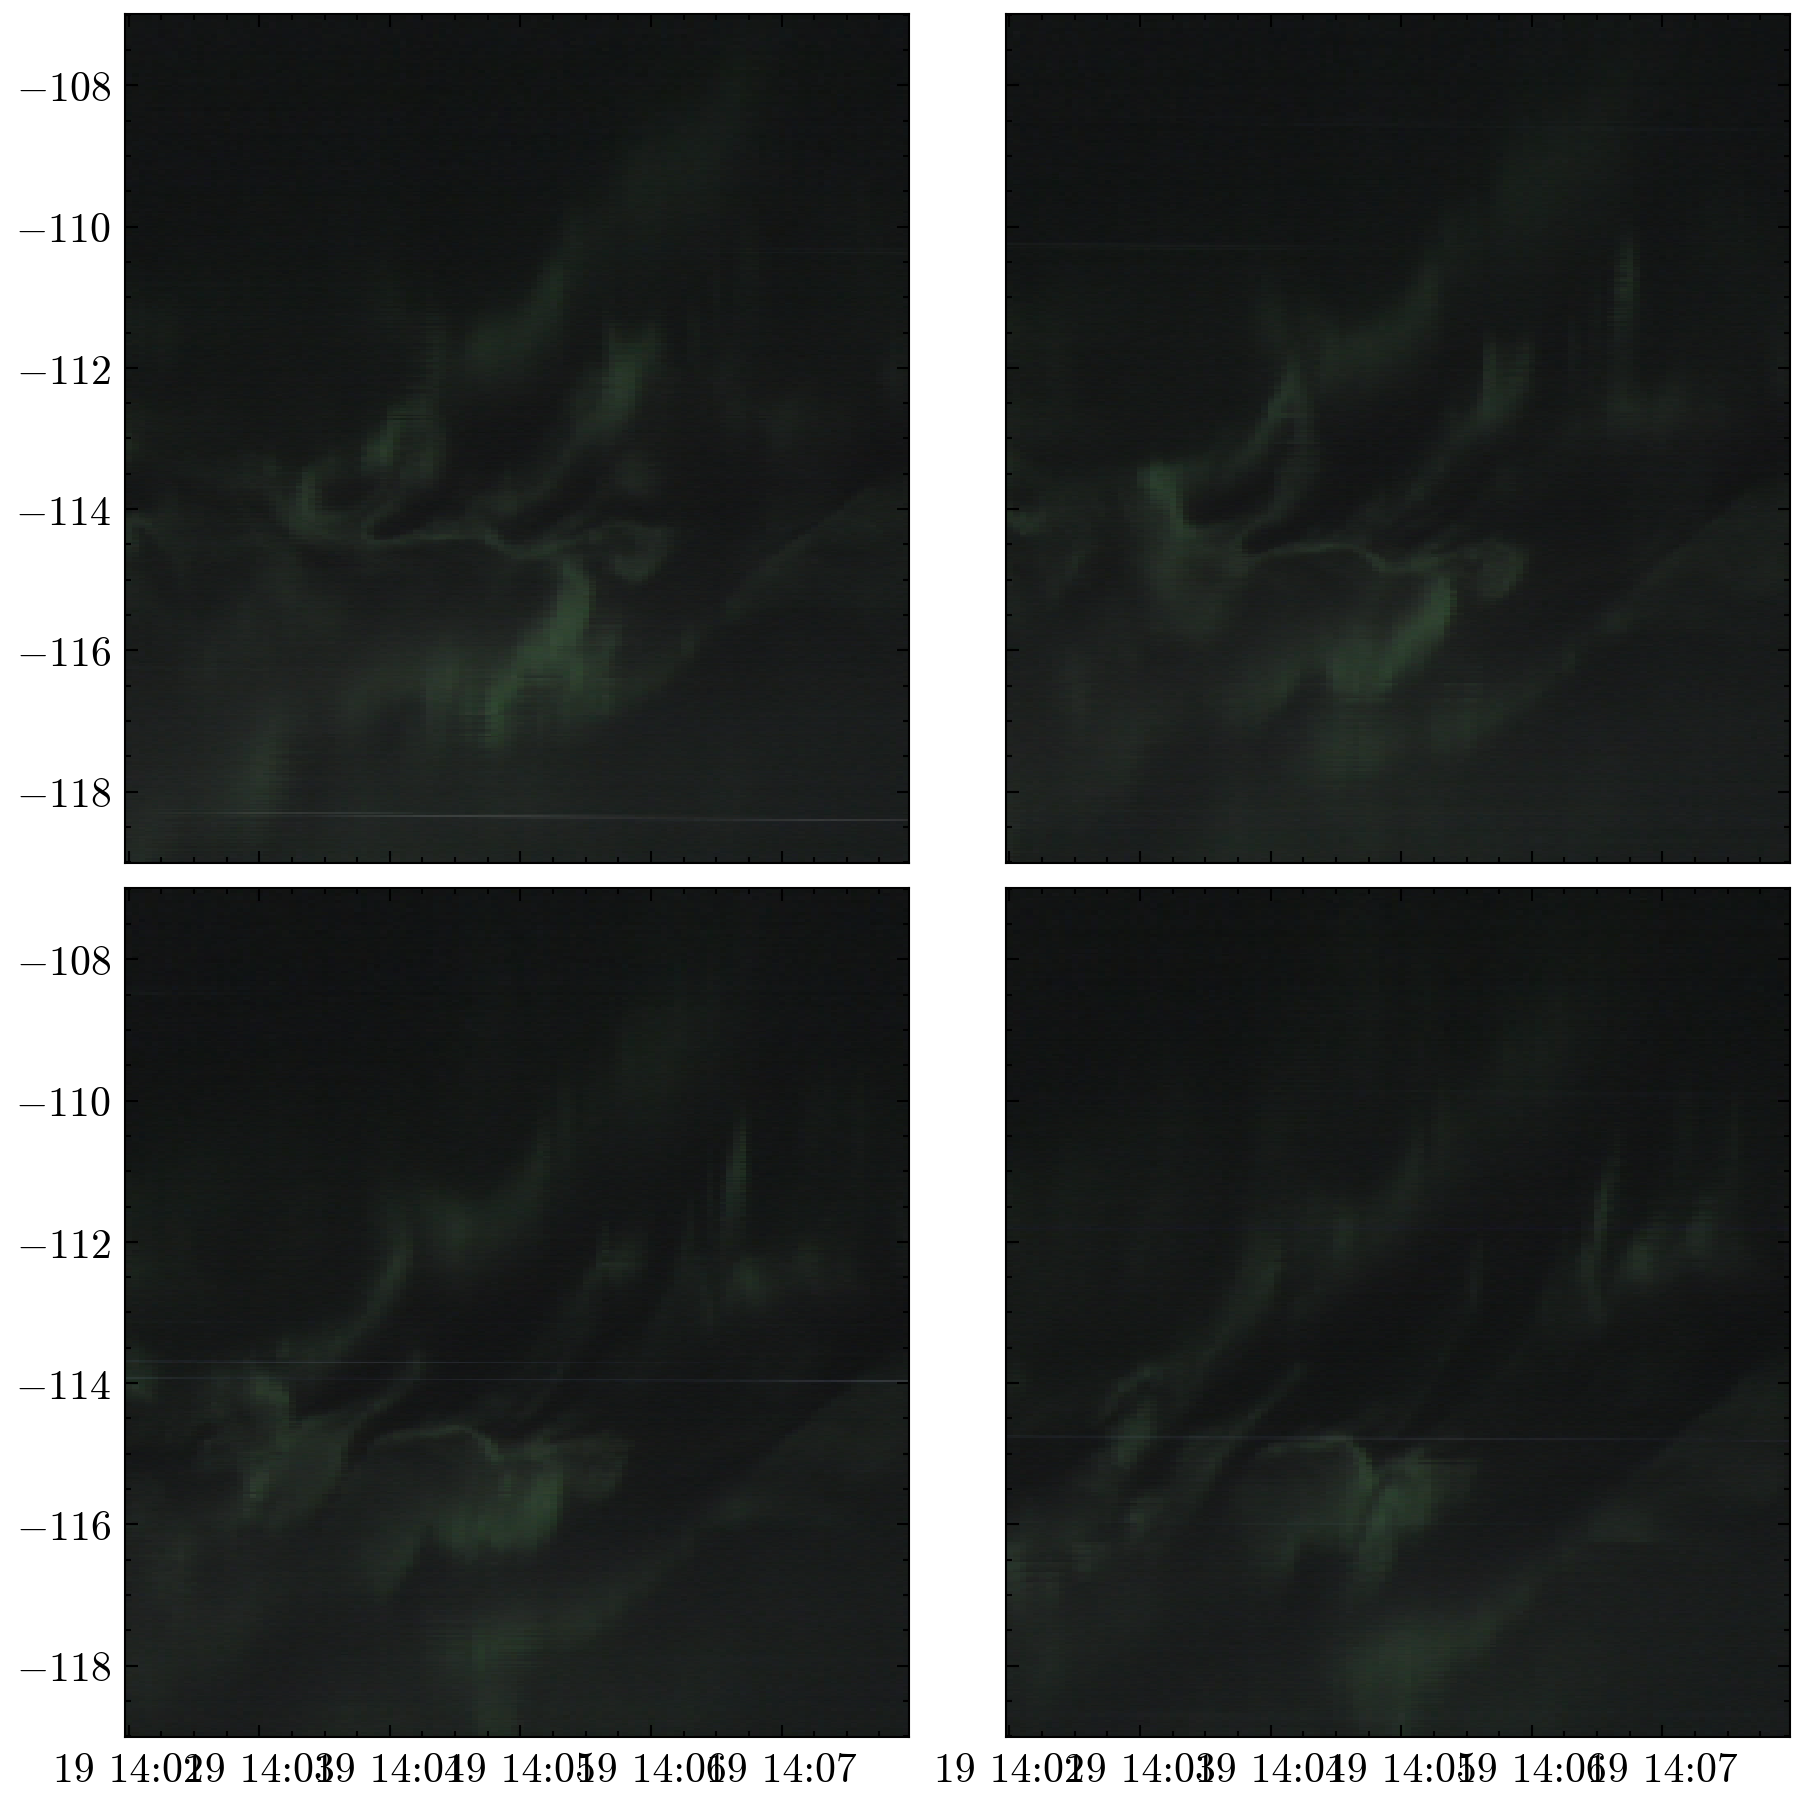

In [23]:
fig, ax = plt.subplots(figsize=(6,6), dpi=300, nrows=2,ncols=2, constrained_layout=True, sharex=True, sharey=True)

ax[0][0].pcolormesh( time_ewo, x_1, np.swapaxes(pixel_closest_30, 1, 0 ))
ax[0][1].pcolormesh( time_ewo, x_1, np.swapaxes(pixel_closest_32, 1, 0 ))
ax[1][0].pcolormesh( time_ewo, x_1, np.swapaxes(pixel_closest_34, 1, 0 ))
ax[1][1].pcolormesh( time_ewo, x_1, np.swapaxes(pixel_closest_36, 1, 0 ))

Distance: 67.49 km
Time: 85.0 s
Velocity: 0.7940073281220439
Distance: 80.36 km
Time: 90.0 s
Velocity: 0.8929137817388475
Distance: 108.73 km
Time: 115.0 s
Velocity: 0.9454867705822165
Distance: 113.76 km
Time: 115.0 s
Velocity: 0.9891868623024784


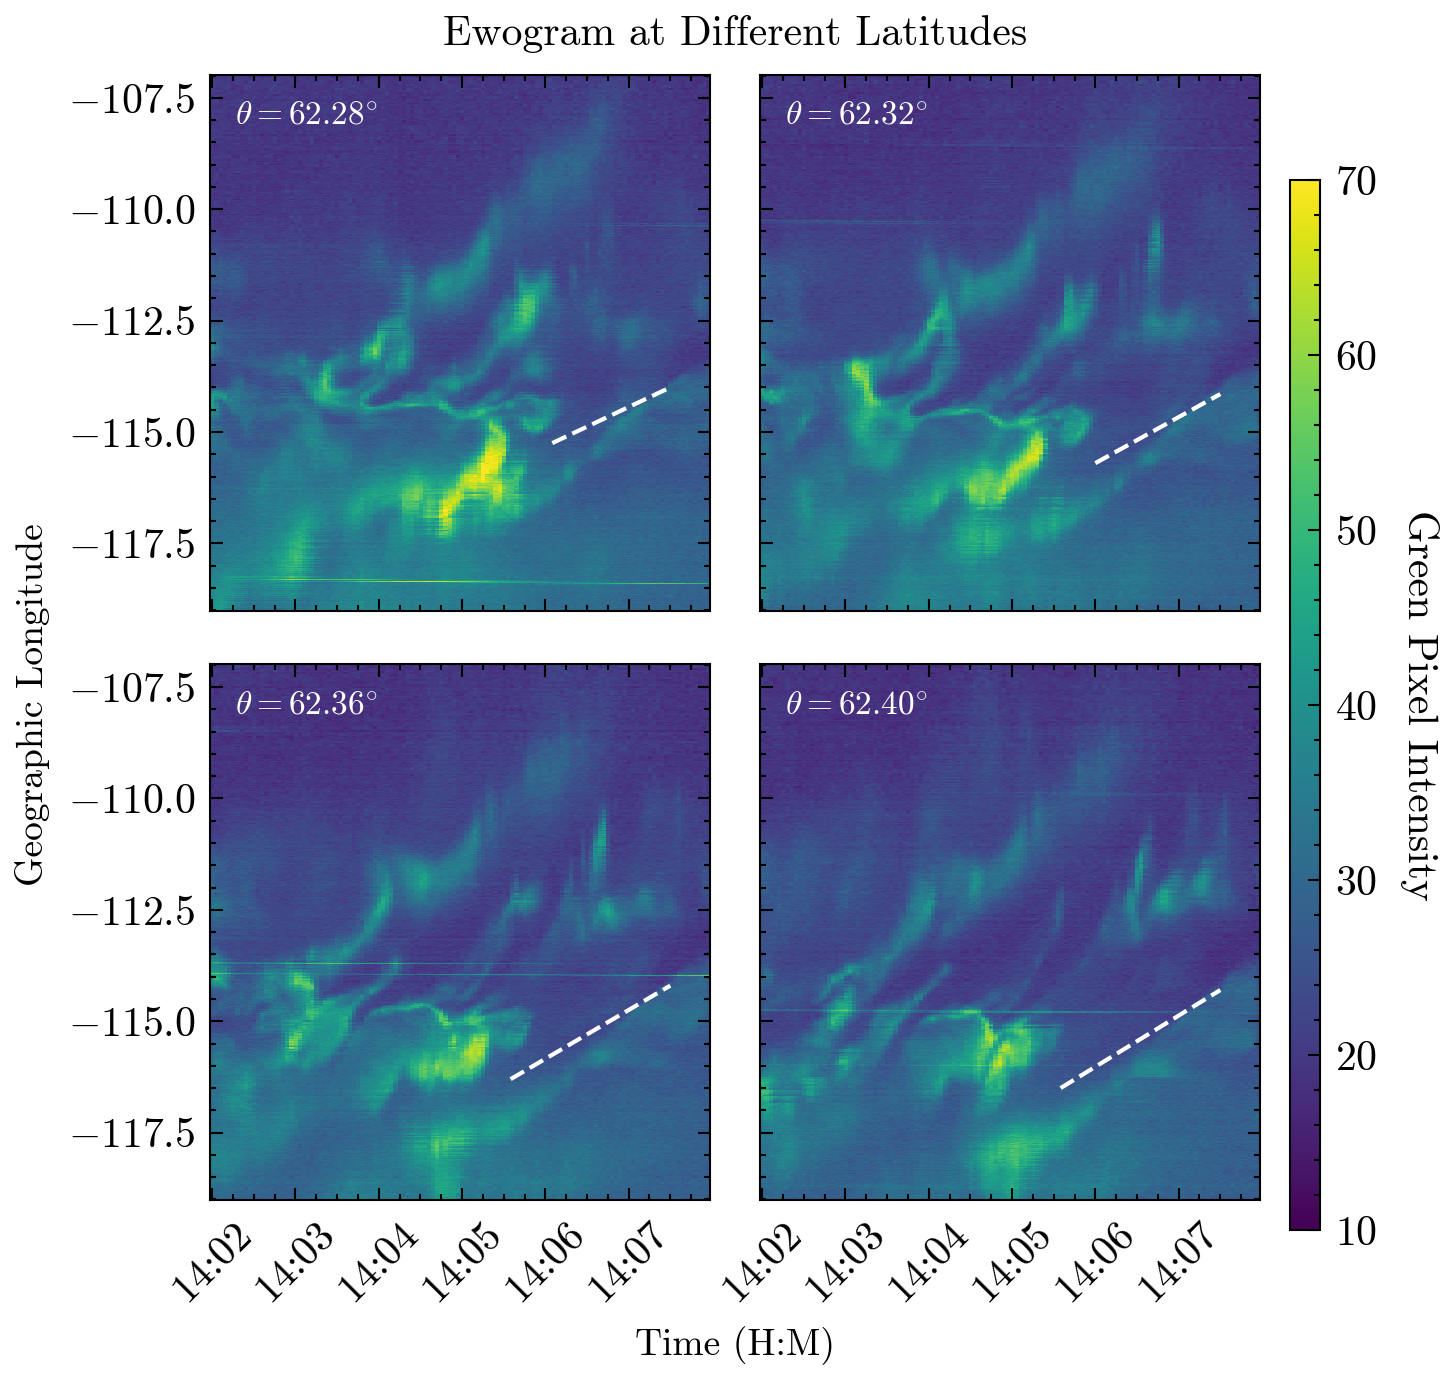

In [25]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from geopy.distance import geodesic

# Create the figure and subplots with further reduced white space
fig, ax = plt.subplots(figsize=(5,5), dpi=300, nrows=2, ncols=2, sharex=True, sharey=True)

# Plot the data
ax[0][0].pcolormesh(time_ewo, x_1, np.swapaxes(pixel_closest_30, 1, 0 )[:,:,1], vmin=10, vmax=70)
ax[0][1].pcolormesh(time_ewo, x_1, np.swapaxes(pixel_closest_32, 1, 0 )[:,:,1], vmin=10, vmax=70)
ax[1][0].pcolormesh(time_ewo, x_1, np.swapaxes(pixel_closest_34, 1, 0 )[:,:,1], vmin=10, vmax=70)
im = ax[1][1].pcolormesh(time_ewo, x_1, np.swapaxes(pixel_closest_36, 1, 0 )[:,:,1], vmin=10, vmax=70)

# Adjust subplot parameters to minimize white space even more
fig.subplots_adjust(left=0.15, right=0.85, top=0.92, bottom=0.17, hspace=0.1, wspace=0.1)

# Adjust colorbar positioning (narrower and closer to subplots)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Green Pixel Intensity', rotation=-90, labelpad=15 ) 
# Set x-axis formatters
locator = mdates.MinuteLocator(interval=1)  # Shows every minute
formatter = mdates.DateFormatter('%H:%M')

for axes in ax.flat:
    axes.xaxis.set_major_locator(locator)
    axes.xaxis.set_major_formatter(formatter)
    axes.tick_params(axis='x', rotation=45)

# Set titles and labels
fig.suptitle("Ewogram at Different Latitudes", fontsize=10, y=0.96)  # Title closer to subplots
fig.supxlabel(r"Time (H:M)", fontsize=9, y=0.06)  # X label closer to bottom
fig.supylabel(r"Geographic Longitude", fontsize=9)  # Y label closer to left

# Add text labels to each subplot with minimal spacing
latitudes = [62.28, 62.32, 62.36, 62.40]
ax[0][0].text(0.05, 0.95, f"$\\theta={latitudes[0]:.2f}^{{\\circ}}$", ha='left', va='top', transform=ax[0][0].transAxes, color='white', fontsize=8)
ax[0][1].text(0.05, 0.95, f"$\\theta={latitudes[1]:.2f}^{{\\circ}}$", ha='left', va='top', transform=ax[0][1].transAxes, color='white', fontsize=8)
ax[1][0].text(0.05, 0.95, f"$\\theta={latitudes[2]:.2f}^{{\\circ}}$", ha='left', va='top', transform=ax[1][0].transAxes, color='white', fontsize=8)
ax[1][1].text(0.05, 0.95, f"$\\theta={latitudes[3]:.2f}^{{\\circ}}$", ha='left', va='top', transform=ax[1][1].transAxes, color='white', fontsize=8)

#ax1

start_datetime = pd.Timestamp('2022-12-19 14:06:05')
end_datetime = pd.Timestamp('2022-12-19 14:07:30')
start_longitude = -115.25
end_longitude = -114.0
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)

coord1 = (62.28, -115.3)  
coord2 = (62.28, -114.0)   

# Calculate the distance
distance = geodesic(coord1, coord2).kilometers




# Generate longitude values
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
ax[0][0].plot(date_range, longitude_values, color='white', linestyle='dashed')
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")
#ax2
start_datetime = pd.Timestamp('2022-12-19 14:06')
end_datetime = pd.Timestamp('2022-12-19 14:07:30')
start_longitude = -115.7
end_longitude = -114.15
coord1 = (62.32, start_longitude)  # Los Angeles, CA
coord2 = (62.32, end_longitude )   # New York, NY

# Calculate the distance
distance = geodesic(coord1, coord2).kilometers
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)

# Generate longitude values
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
ax[0][1].plot(date_range, longitude_values, color='white', linestyle='dashed')
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")
#ax3
start_datetime = pd.Timestamp('2022-12-19 14:05:35')
end_datetime = pd.Timestamp('2022-12-19 14:07:30')
start_longitude = -116.3
end_longitude = -114.2
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)

coord1 = (62.36, start_longitude)  # Los Angeles, CA
coord2 = (62.36, end_longitude )   # New York, NY
distance = geodesic(coord1, coord2).kilometers
# Generate longitude values
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
ax[1][0].plot(date_range, longitude_values, color='white', linestyle='dashed')
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")
#ax4
start_datetime = pd.Timestamp('2022-12-19 14:05:35')
end_datetime = pd.Timestamp('2022-12-19 14:07:30')
start_longitude = -116.5
end_longitude = -114.3
date_range = pd.date_range(start=start_datetime, end=end_datetime, periods=100)
coord1 = (62.4, start_longitude)  # Los Angeles, CA
coord2 = (62.4, end_longitude )   # New York, NY
distance = geodesic(coord1, coord2).kilometers
# Generate longitude values
longitude_values = np.linspace(start_longitude, end_longitude, num=100)
ax[1][1].plot(date_range, longitude_values, color='white', linestyle='dashed')
print(f"Distance: {distance:.2f} km")
print(f"Time: {(end_datetime - start_datetime).total_seconds()} s")
print(f"Velocity: {distance / (end_datetime - start_datetime).total_seconds() }")
